# SciKit-LearnML Experimentation

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

from classifier_utilities import *

### importing datasets

In [2]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

"""
l8_image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028012_20140814_20171017_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']
"""

l8_image_paths = ['/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

s1_image_paths = ['/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif']

landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))



In [3]:
# What is the raster's projection?
image_proj = landsat_datasets[0].crs # 4326
print('Image projection:')
print(image_proj)
print('---')
# What is the raster's projection?
label_proj = sentinel_datasets[0].crs
print('Labels projection:')
print(label_proj)
print('---')
# What is the raster's projection?
label_proj = label_dataset.crs
print('Labels projection:')
print(label_proj)

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
---
Labels projection:
EPSG:4326
---
Labels projection:
EPSG:32618


### Class Dictionary and Confusion Matrix Function

In [4]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

## Scikit-learn ML Approaches

### Prep Data for training and validation

In [9]:
# get pixel locations
train_px, val_px = gen_pixel_locations(landsat_datasets, 5000, 1000, 1)

In [10]:
# get training data from those pixel locations
batch_size = 5000
sk_im_batch, sk_label_batch = pixel_generator(landsat_datasets, sentinel_datasets, label_dataset, train_px, batch_size)
print(sk_im_batch.shape, sk_label_batch.shape)

(5000, 9) (5000, 26)


In [11]:
# get validation data from those pixel locations
batch_size = 1000
sk_im_batch_val, sk_label_batch_val = pixel_generator(landsat_datasets, sentinel_datasets, label_dataset, val_px, batch_size)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

(1000, 9) (1000, 26)


### K Nearest Neighbors

Create an instance of Neighbours Classifier and fit the data.

In [12]:
from sklearn import neighbors, datasets

n_neighbors = 50

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=50, p=2,
           weights='distance')

Now assess the model

In [13]:
label_index = np.argmax(sk_label_batch_val, axis=1)

clf.score(sk_im_batch_val, label_index)

0.413

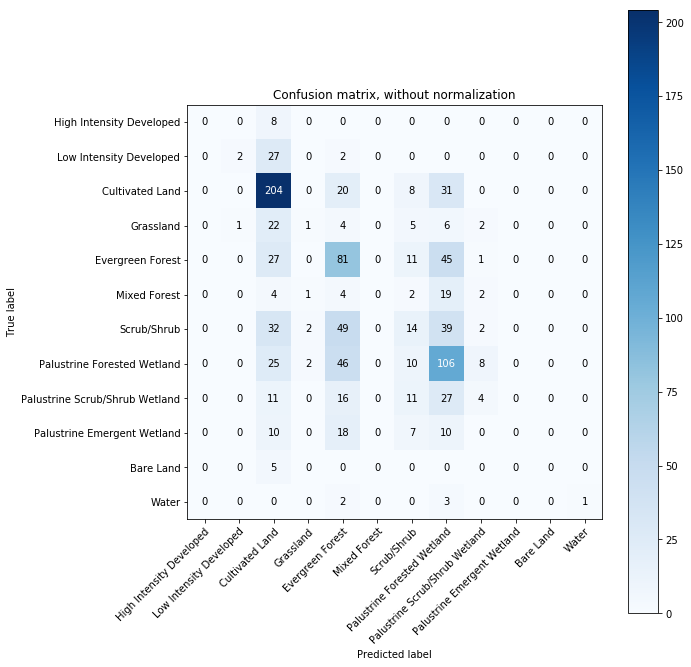

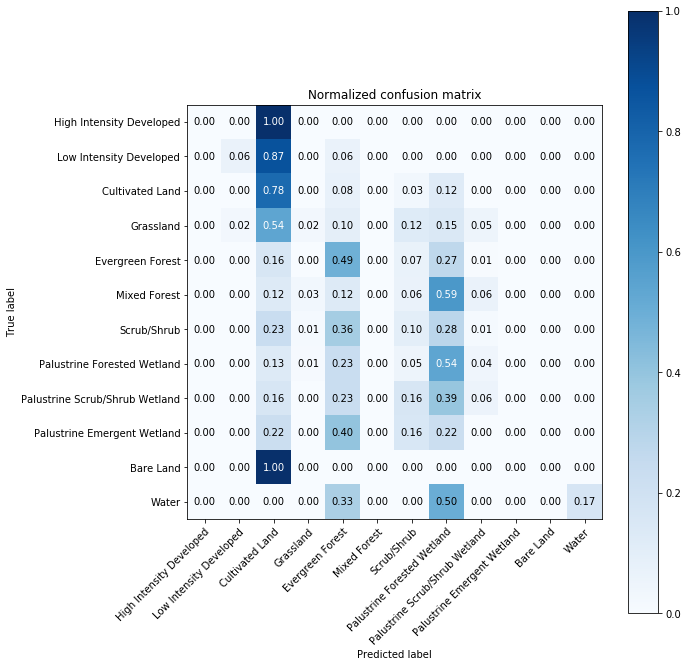

In [14]:
pred_index = clf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

(array([  8.,   0.,  31.,   0., 263.,   0.,  41.,   0., 165.,  32., 138.,
        197.,  69.,  45.,   0.,   0.,   0.,   0.,   5.,   6.]),
 array([ 2.  ,  2.95,  3.9 ,  4.85,  5.8 ,  6.75,  7.7 ,  8.65,  9.6 ,
        10.55, 11.5 , 12.45, 13.4 , 14.35, 15.3 , 16.25, 17.2 , 18.15,
        19.1 , 20.05, 21.  ]),
 <a list of 20 Patch objects>)

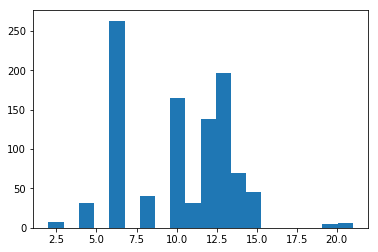

In [15]:
plt.hist(np.argmax(sk_label_batch_val, axis=1), bins=20)

(array([  3.,   0., 375.,   0.,   6.,   0.,   0., 242.,   0.,  68., 286.,
         19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 4.  ,  4.85,  5.7 ,  6.55,  7.4 ,  8.25,  9.1 ,  9.95, 10.8 ,
        11.65, 12.5 , 13.35, 14.2 , 15.05, 15.9 , 16.75, 17.6 , 18.45,
        19.3 , 20.15, 21.  ]),
 <a list of 20 Patch objects>)

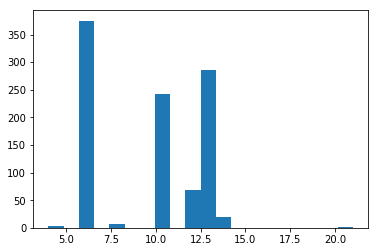

In [16]:
plt.hist(pred_index, bins=20)

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [18]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 77.46%


In [19]:
rf.score(sk_im_batch_val, label_index)

0.443

In [20]:
bands = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.008282453853363307
Band 2 importance: 0.13400115895899992
Band 3 importance: 0.16003517048344526
Band 4 importance: 0.1369852318037735
Band 5 importance: 0.007594935000442107
Band 6 importance: 0.1461378971948952
Band 7 importance: 0.1524540890449129
Band 8 importance: 0.12652233116532452
Band 9 importance: 0.12798673249484332


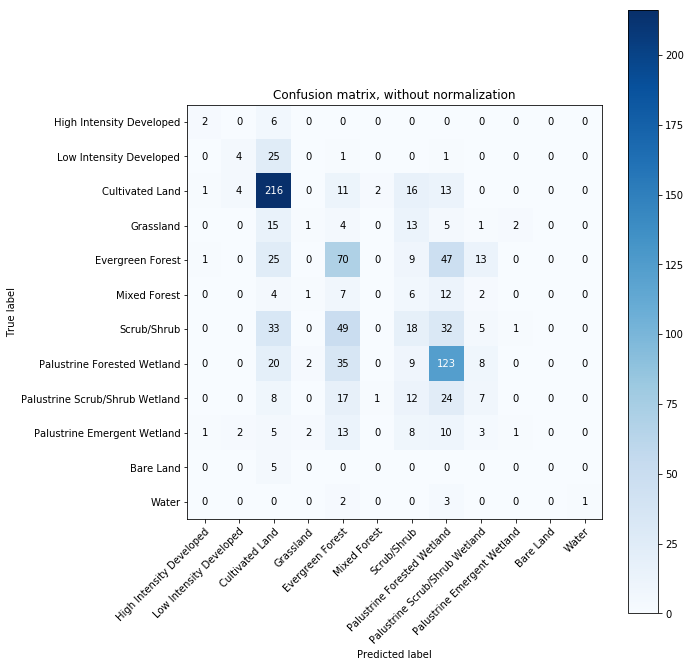

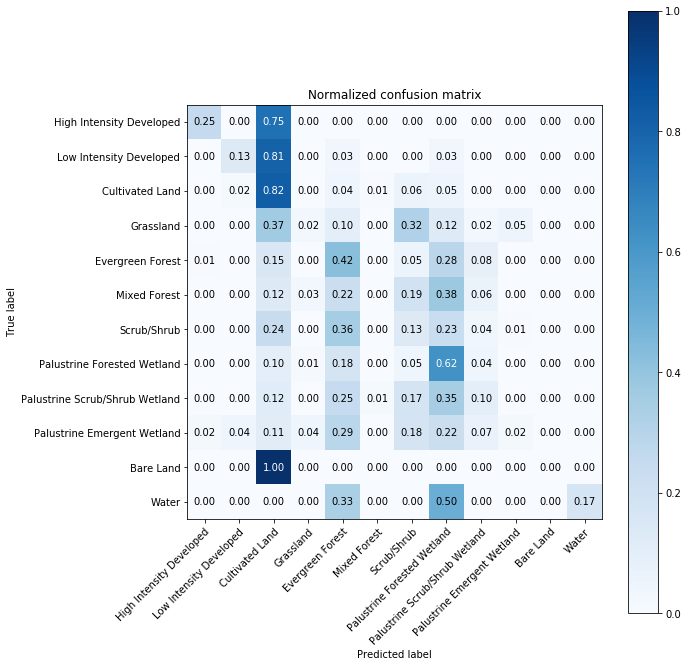

In [21]:
pred_index = rf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

(array([  5.,   0.,  10.,   0., 362.,   0.,   6.,   0., 209.,   3.,  91.,
        270.,  39.,   4.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 2.  ,  2.95,  3.9 ,  4.85,  5.8 ,  6.75,  7.7 ,  8.65,  9.6 ,
        10.55, 11.5 , 12.45, 13.4 , 14.35, 15.3 , 16.25, 17.2 , 18.15,
        19.1 , 20.05, 21.  ]),
 <a list of 20 Patch objects>)

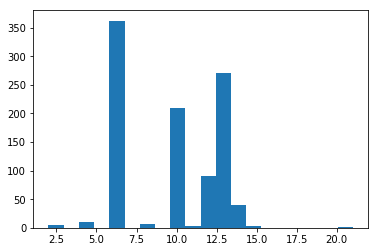

In [22]:
plt.hist(pred_index, bins=20)

#### Creating training data that contains a 3x3 tile

In [109]:
batch_size = 50000
sk_im_batch, sk_label_batch = sk_tile_generator(landsat_datasets, sentinel_datasets, label_dataset, 3, 3, train_px, batch_size)
print(sk_im_batch.shape, sk_label_batch.shape)

wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
(50000, 63) (50000, 23)


In [108]:
batch_size = 1000
sk_im_batch_val, sk_label_batch_val = sk_tile_generator([landsat_dataset], label_dataset, 3, 3, val_px, batch_size)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

(1000, 63) (1000, 23)


In [110]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [111]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 100.0%


In [112]:
label_index = np.argmax(sk_label_batch_val, axis=1)

rf.score(sk_im_batch_val, label_index)

0.488

In [113]:
bands = [1, 2, 3, 4, 5, 6, 7]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.022661240266950693
Band 2 importance: 0.015913569474774642
Band 3 importance: 0.015443475641588156
Band 4 importance: 0.011884559956153513
Band 5 importance: 0.011781815585605575
Band 6 importance: 0.012572999001945315
Band 7 importance: 0.013389758830972695


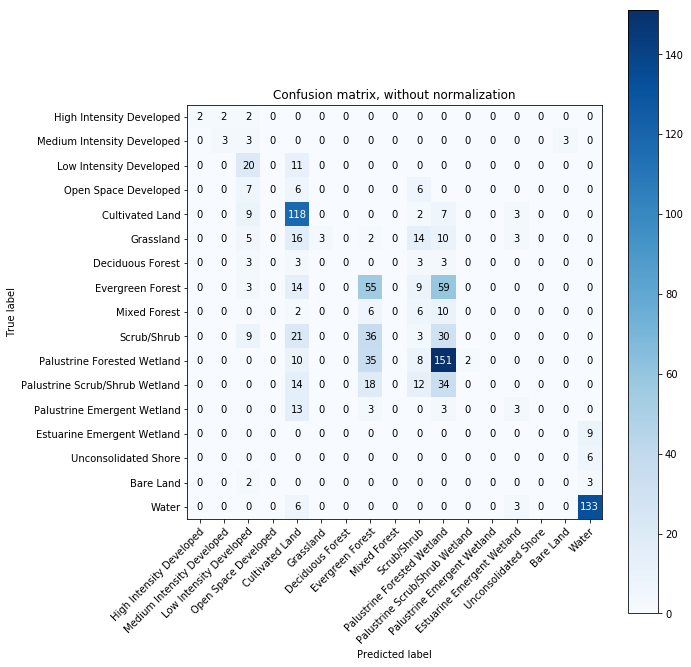

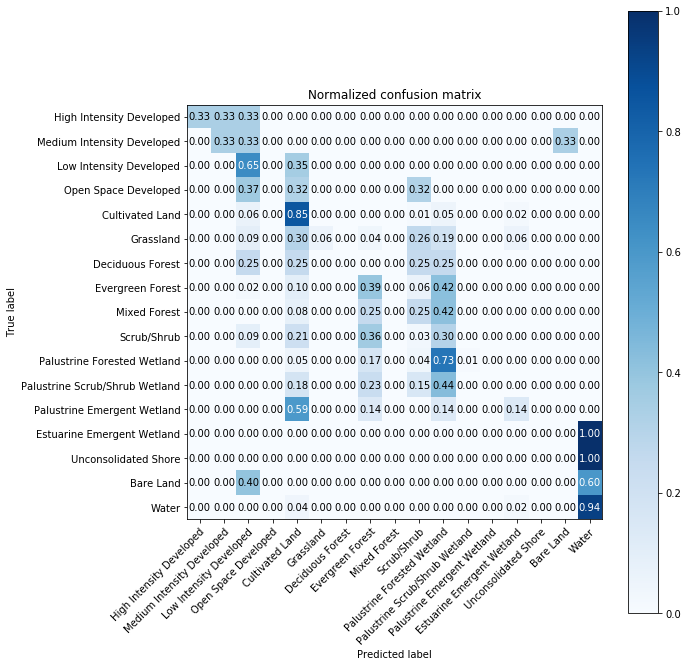

In [114]:
pred_index = rf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

### SVM

In [115]:
from sklearn import svm
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [116]:
svm_clf.score(sk_im_batch_val, np.argmax(sk_label_batch_val, axis=1))

0.441

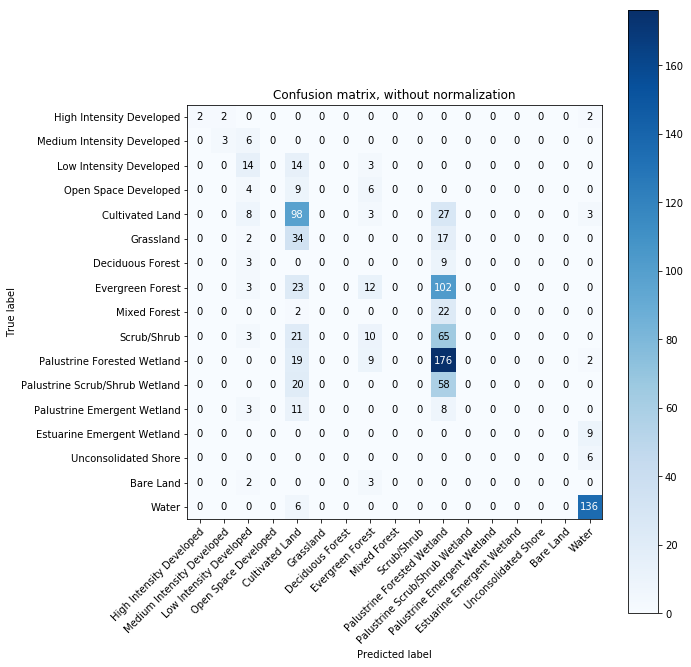

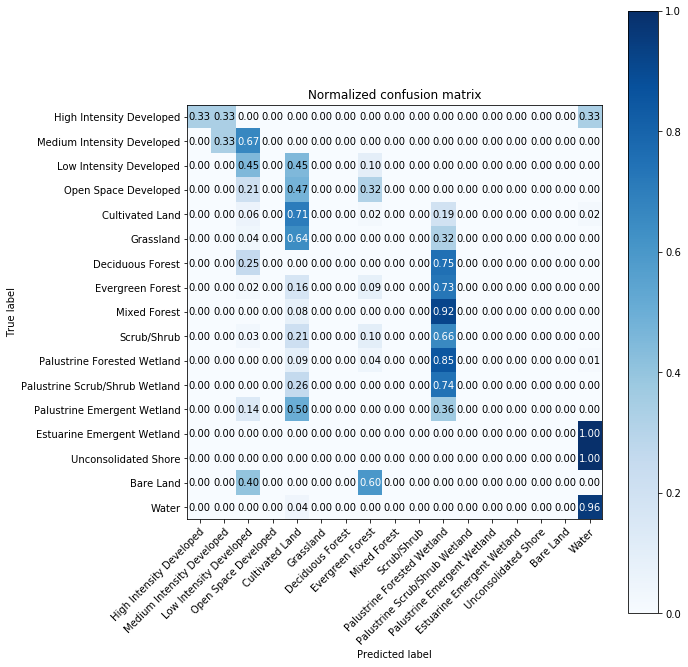

In [117]:
pred_index = svm_clf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [24]:
sk_im_batch, sk_label_batch = sk_tile_generator(landsat_datasets, label_dataset, 3, 3, train_px, batch_size)

wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape


In [25]:
print(sk_im_batch.shape, sk_label_batch.shape)

(50000, 72) (50000, 23)
